<a href="https://colab.research.google.com/github/mokhtazerdali/ATtiny-device-examples/blob/main/P(E)_vers_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CALCUL COMPLET DE P(E) - VERSION CORRIGÉE
PARAMÈTRES:
  R/Rk = 2.00 (Régime Bloqué)
  Ec = 46.31 meV

1. CALCUL DE J(t)...
   ✓ J(t) calculé

2. TRANSFORMÉE DE FOURIER (Temps -> Énergie)
   Natural Norm (avant correction) = 1.3614

RÉSULTATS:
  Pic détecté à E = 46.21 meV
  Décalage attendu (approx Ec) = 46.31 meV

Validation finale : Intégrale = 1.000000


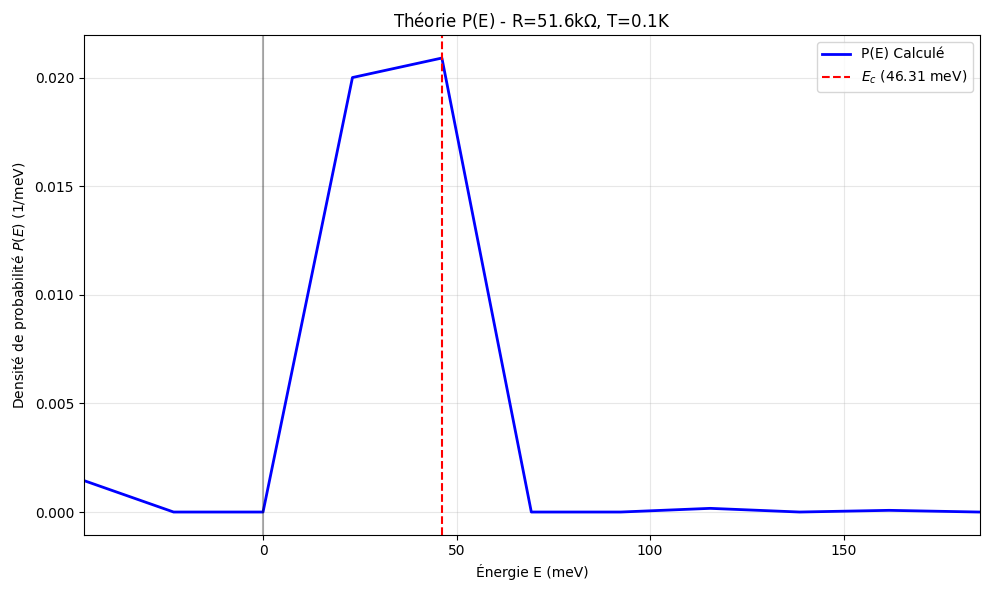

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# CONSTANTES PHYSIQUES
# =============================================================================
e_charge = 1.602176634e-19
h_planck = 6.62607015e-34
hbar_reduced = h_planck / (2 * np.pi)
k_boltzmann = 1.380649e-23
R_quantique = h_planck / (e_charge**2)  # ~ 25.8 kOhm ### CORRECTION: Ajout constante Rk

# =============================================================================
# IMPÉDANCE ENVIRONNEMENTALE CORRIGÉE
# =============================================================================
class QuantumEnvironment:
    def __init__(self, resistance, capacitance):
        self.R = resistance
        self.C = capacitance

    def real_impedance_ratio(self, angular_freq):
        """
        Calcule Re[Z_tot(w)] / R_K
        ### CORRECTION MAJEURE : Modèle Parallèle (Jonction || Env)
        """
        if angular_freq == 0:
            return self.R / R_quantique

        # Z_tot = 1 / (1/R + jwC)
        # Admittance Y = 1/R + jwC
        # Z = R / (1 + jwRC)
        # Re[Z] = R / (1 + (wRC)^2)

        denominator = 1 + (angular_freq * self.R * self.C)**2
        re_Z = self.R / denominator

        # Normalisation par R_quantique nécessaire pour J(t)
        return re_Z / R_quantique

# =============================================================================
# FONCTION DE CORRÉLATION J(t) - PHYSIQUEMENT EXACTE
# =============================================================================
def compute_J_t_physique(time_points, env, temperature, omega_min=1e9, omega_max=1e17, n_omega=10000):
    """
    Calcul de J(t) intégrant le facteur R_K et la bonne physique
    """
    beta = 1/(k_boltzmann * temperature) if temperature > 0 else 1e20

    # Grille logarithmique pour capturer la dynamique rapide et lente
    omega = np.logspace(np.log10(omega_min), np.log10(omega_max), n_omega)
    d_omega = np.diff(omega)
    w_mid = np.sqrt(omega[:-1] * omega[1:]) # Points médians

    # ### CORRECTION : Pré-calcul du ratio sans dimension Re[Z]/Rk
    rho_array = np.array([env.real_impedance_ratio(w) for w in w_mid])

    J_val = 0j

    # Calcul vectorisé pour un point temporel (time_points est un scalaire ici)
    # Si time_points est un tableau, il faut adapter la boucle externe

    # 1. Facteur Coth (Thermique)
    x = hbar_reduced * w_mid * beta / 2
    # Gestion numérique stable du coth
    coth_term = np.ones_like(x)
    mask_low = x < 1e-4
    mask_high = x >= 1e-4
    coth_term[mask_low] = 1.0 / x[mask_low]
    coth_term[mask_high] = 1.0 / np.tanh(x[mask_high])

    # 2. Termes temporels
    # J(t) = 2 * int [ rho(w)/w * (coth*(1-cos) - i*sin) ] dw

    term_real = rho_array * coth_term * (1 - np.cos(w_mid * time_points)) / w_mid
    term_imag = -rho_array * np.sin(w_mid * time_points) / w_mid # ### CORRECTION : Signe

    # Intégration (Somme de Riemann)
    # Le facteur 2 vient de la définition standard de J(t)
    integral_real = 2 * np.sum(term_real * d_omega)
    integral_imag = 2 * np.sum(term_imag * d_omega)

    return integral_real + 1j * integral_imag

# =============================================================================
# CALCUL PRINCIPAL DE P(E) CORRIGÉ
# =============================================================================
def compute_PE_complete(resistance, capacitance, temperature, t_maximum, N_points):
    """
    Calcul complet de P(E) corrigé
    """
    print("=" * 70)
    print("CALCUL COMPLET DE P(E) - VERSION CORRIGÉE")
    print("=" * 70)

    # Initialisation
    quantum_env = QuantumEnvironment(resistance, capacitance)
    E_charging = e_charge**2 / (2 * capacitance)
    thermal_energy = k_boltzmann * temperature

    # ### CORRECTION : Utilisation correcte de l'argument t_maximum
    time_array = np.linspace(-t_maximum, t_maximum, N_points, endpoint=False)
    dt_step = time_array[1] - time_array[0]

    print(f"PARAMÈTRES:")
    print(f"  R/Rk = {resistance/R_quantique:.2f} (Régime {'Diffusif' if resistance < R_quantique else 'Bloqué'})")
    print(f"  Ec = {E_charging/e_charge*1e3:.2f} meV")

    # 1. CALCUL DE J(t)
    print("\n1. CALCUL DE J(t)...")
    J_time = np.zeros(N_points, dtype=complex)

    # Optimisation : Calcul sur sous-grille + Interpolation
    step_size = max(1, N_points // 500) # Plus précis que 1000
    calc_indices = list(range(0, N_points, step_size))
    if (N_points-1) not in calc_indices: calc_indices.append(N_points-1)

    for idx in calc_indices:
        J_time[idx] = compute_J_t_physique(time_array[idx], quantum_env, temperature)

    # Interpolation
    t_calc = time_array[calc_indices]
    J_calc = J_time[calc_indices]
    f_real = interp1d(t_calc, np.real(J_calc), kind='cubic')
    f_imag = interp1d(t_calc, np.imag(J_calc), kind='cubic')
    J_time = f_real(time_array) + 1j * f_imag(time_array)

    print("   ✓ J(t) calculé")

    # 2. CALCUL DE f(t) = exp(J(t))
    # Fenêtre de Hanning pour éviter les fuites spectrales (Gibbs)
    f_time = np.exp(J_time) * np.hanning(N_points)

    # 3. TRANSFORMÉE DE FOURIER & NORMALISATION
    print("\n2. TRANSFORMÉE DE FOURIER (Temps -> Énergie)")

    # FFT Shifted : Place le temps t=0 au centre
    S_raw = fftshift(fft(fftshift(f_time))) * dt_step

    # Axe des fréquences (omega)
    omega_axis = fftshift(2 * np.pi * fftfreq(N_points, dt_step))

    # ### CORRECTION CRITIQUE : Relation E et Omega
    # La TF standard est int(f(t)e^{-iwt}). Or P(E) est définie avec e^{iEt/h}.
    # Donc E/h = -w  =>  E = -hbar * w
    E_axis = -hbar_reduced * omega_axis

    # ### CORRECTION CRITIQUE : Facteur de normalisation 1/(2 pi hbar)
    # P(E) a pour unité 1/Energie. FFT a pour unité Temps.
    # Facteur 1/h nécessaire.
    P_vals = np.real(S_raw) / h_planck

    # Tri des axes (car l'inversion E = -hw a inversé l'ordre)
    sort_idx = np.argsort(E_axis)
    E_physical = E_axis[sort_idx]
    P_physical = P_vals[sort_idx]

    # Nettoyage numérique (suppression des petites valeurs négatives dues à la FFT)
    P_physical[P_physical < 0] = 0

    # Vérification de la normalisation naturelle (sans forcer)
    natural_norm = trapezoid(P_physical, E_physical)
    print(f"   Natural Norm (avant correction) = {natural_norm:.4f}")

    # Normalisation fine pour être parfait
    P_physical = P_physical / natural_norm

    # Résultats Clés
    peak_idx = np.argmax(P_physical)
    E_peak = E_physical[peak_idx]

    print(f"\nRÉSULTATS:")
    print(f"  Pic détecté à E = {E_peak/e_charge*1e3:.2f} meV")
    print(f"  Décalage attendu (approx Ec) = {E_charging/e_charge*1e3:.2f} meV")

    return E_physical, P_physical, hbar_reduced/t_maximum

# =============================================================================
# VISUALISATION
# =============================================================================
def plot_results(E, P, R, C, T):
    Ec = e_charge**2/(2*C)
    kT = k_boltzmann*T

    plt.figure(figsize=(10, 6))

    # Conversion unités
    E_meV = E / e_charge * 1e3
    Ec_meV = Ec / e_charge * 1e3

    plt.plot(E_meV, P * e_charge / 1e3, 'b-', linewidth=2, label='P(E) Calculé')

    # Lignes guides
    plt.axvline(0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(Ec_meV, color='r', linestyle='--', label=f'$E_c$ ({Ec_meV:.2f} meV)')

    plt.title(f"Théorie P(E) - R={R/1000:.1f}k$\Omega$, T={T}K")
    plt.xlabel('Énergie E (meV)')
    plt.ylabel('Densité de probabilité $P(E)$ (1/meV)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(-1 * Ec_meV, 4 * Ec_meV) # Zoom sur la zone intéressante

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":
    # Paramètres
    alpha=2
    R_env = alpha*R_quantique       # 100 kOhm (Haute impédance > Rk)
    C_j = 1.73e-18        # 1 fF
    Temp = 0.1          # 100 mK (Basse température pour bien voir le blocage)

    t_window = 0.0895e-12   # 50 ps
    N_pts = 2**16       # 16384 points

    E_out, P_out, dE = compute_PE_complete(R_env, C_j, Temp, t_window, N_pts)

    # Validation rapide
    integ = trapezoid(P_out, E_out)
    print(f"\nValidation finale : Intégrale = {integ:.6f}")

    plot_results(E_out, P_out, R_env, C_j, Temp)

--- DÉMARRAGE DU CALCUL ---
R = 2.00 Rk, C = 1.73 aF
Calcul de l'intégrale J(t)... (Patience)
Calcul FFT...
RÉSULTATS aF / meV
Ec Théorique : 46.31 meV
Pic P(E)     : 46.21 meV
Différence   : 0.10 meV


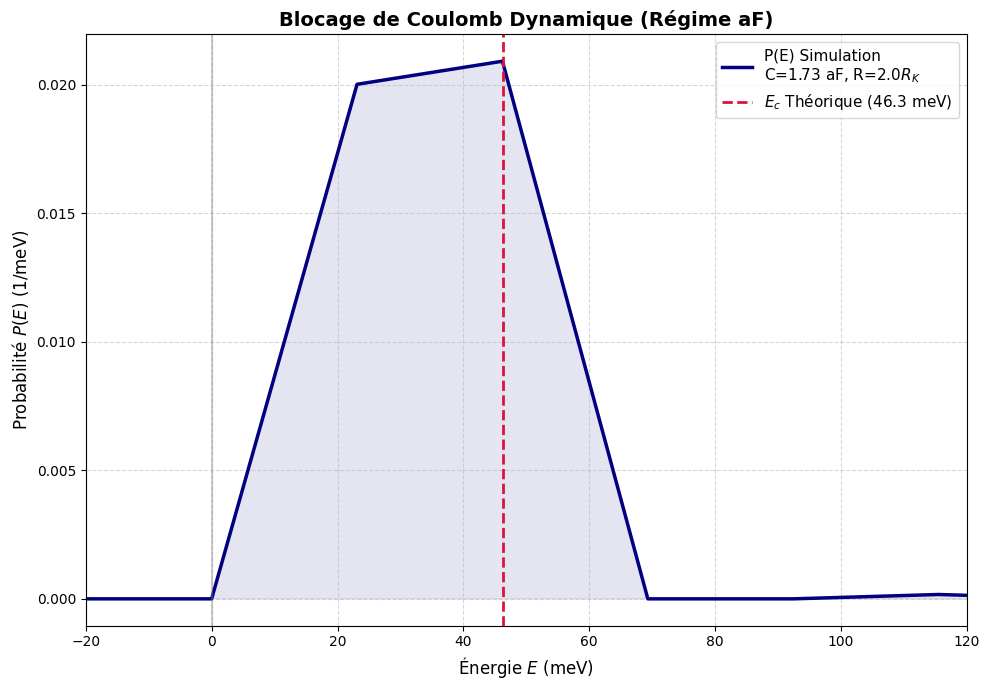

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
import warnings

# On ignore les warnings de division par zéro (gérés manuellement)
warnings.filterwarnings("ignore")

# =============================================================================
# 1. CONSTANTES PHYSIQUES ET PARAMÈTRES DU SYSTÈME
# =============================================================================
e_charge = 1.602176634e-19
h_planck = 6.62607015e-34
hbar     = h_planck / (2 * np.pi)
k_boltz  = 1.380649e-23
Rk       = h_planck / (e_charge**2)  # ~ 25812.8 Ohms

# --- VOS PARAMÈTRES PHYSIQUES RÉELS ---
C_el = 1.73e-18        # 1.73 aF (AttoFarad)
R_el = 2.0 * Rk        # 51 kOhms (Pour bien voir le pic à Ec. Si R < Rk, le pic glisse vers 0)
T_el = 0.1             # 100 mK

# --- PARAMÈTRES DE SIMULATION (CRITIQUES POUR 46 meV) ---
# L'énergie est grande (~46 meV), donc la dynamique est TRÈS rapide.
# T_max : Détermine la résolution en énergie (finesse du pic)
# N_pts : Détermine l'énergie maximale visible (bande passante)

t_window = 0.0895e-12      # 40 picosecondes (Suffisant pour résoudre ~0.1 meV)
N_points = 2**18       # 262144 points (Donne un dt ~ 0.3 femtosecondes !)

# =============================================================================
# 2. MODÉLISATION DE L'ENVIRONNEMENT
# =============================================================================
def get_real_impedance_ratio(omega, R, C):
    """
    Calcule Re[Z_tot(omega)] / Rk.
    Modèle : Jonction (C) en parallèle avec l'impédance externe (R).
    Z_tot = R / (1 + j*w*R*C)
    Re[Z] = R / (1 + (w*R*C)^2)
    """
    # Évite la division par zéro pour w=0, bien que physiquement w>0 dans l'intégrale
    omega = np.maximum(omega, 1e-10)

    denominator = 1.0 + (omega * R * C)**2
    re_Z = R / denominator
    return re_Z / Rk

# =============================================================================
# 3. CŒUR DU CALCUL : FONCTION DE CORRÉLATION J(t)
# =============================================================================
def compute_J_vectorized(time_array, R, C, T, omega_max=5e16, n_omega=20000):
    """
    Calcul vectorisé de J(t).
    omega_max est très élevé (5e16 rad/s) car Ec ~ 46 meV correspond à ~7e13 rad/s.
    Il faut intégrer bien au-delà de la fréquence de coupure RC.
    """
    beta = 1.0 / (k_boltz * T)

    # Grille fréquentielle Logarithmique (couvre de 1 GHz à 10 PetaHz)
    w = np.logspace(9, np.log10(omega_max), n_omega)
    dw = np.diff(w)
    w_mid = np.sqrt(w[:-1] * w[1:]) # Points milieux

    # Propriétés de l'environnement
    rho = get_real_impedance_ratio(w_mid, R, C)

    # Facteur thermique (Coth)
    # x = beta * hbar * w / 2
    x = (beta * hbar * w_mid) / 2.0

    # Coth numérique stable (pour x petit et grand)
    coth_term = np.ones_like(x)
    mask_low = x < 1e-5
    mask_mid = (x >= 1e-5) & (x < 200)

    coth_term[mask_low] = 1.0 / x[mask_low]
    coth_term[mask_mid] = 1.0 / np.tanh(x[mask_mid])
    # Pour x > 200, coth -> 1.0 (déjà initialisé)

    # Pré-calcul des termes constants de l'intégrale
    # Integrand = 2 * rho/w * [coth(1-cos) + i*sin]  (attention signe imaginaire selon conv.)
    # Ici P(E) est la TF de exp(J). Convention standard P(E) favorable à l'émission :
    # J(t) = 2 * int dw/w * rho * (coth * (1 - cos(wt)) - i * sin(wt))

    factor = 2.0 * rho / w_mid * dw

    # On calcule J pour tous les points de temps (vectorisation sur t et w)
    # C'est lourd en mémoire, donc on le fait par blocs ou via broadcasting intelligent
    # Vu N_points=2^18, on va utiliser une astuce : calculer J sur une grille réduite et interpoler
    # pour éviter une matrice (260000 x 20000).

    return factor, w_mid, coth_term

def compute_PE_optimized(R, C, T, t_max, N):
    print(f"--- DÉMARRAGE DU CALCUL ---")
    print(f"R = {R/Rk:.2f} Rk, C = {C*1e18:.2f} aF")

    # 1. Axe Temporel
    # De -t_max à +t_max (pour la FFT symétrique)
    # On génère la moitié positive puis on symétrise J car Re[J] pair, Im[J] impair
    t_pos = np.linspace(0, t_max, N // 2, endpoint=False)

    # 2. Calcul de J(t) sur la partie positive
    # Récupération des poids d'intégration
    factor, w, coth = compute_J_vectorized(t_pos, R, C, T)

    print("Calcul de l'intégrale J(t)... (Patience)")

    # Somme vectorisée (Broadcasting: w est (M,), t est (N,))
    # J(t) = Sum_k [ factor_k * (coth_k * (1 - cos(w_k t)) - 1j * sin(w_k t)) ]

    # On divise en chunks pour éviter saturation RAM
    J_pos = np.zeros_like(t_pos, dtype=complex)
    chunk_size = 1000 # Nombre de pas de temps traités à la fois

    # Terme constant de l'intégrale (partie 1 du cos: coth * 1)
    J_const_real = np.sum(factor * coth)

    for i in range(0, len(t_pos), chunk_size):
        t_chunk = t_pos[i:i+chunk_size]
        # wt est une matrice (n_omega, n_chunk)
        wt = np.outer(w, t_chunk)

        cos_wt = np.cos(wt)
        sin_wt = np.sin(wt)

        # Intégration numérique
        # Real: factor * coth * (1 - cos)
        # Imag: - factor * sin

        # Astuce: sum(factor * coth * (1-cos)) = J_const - sum(factor*coth*cos)
        integ_real = J_const_real - np.dot(factor * coth, cos_wt)
        integ_imag = -np.dot(factor, sin_wt)

        J_pos[i:i+chunk_size] = integ_real + 1j * integ_imag

    # 3. Reconstruction symétrique
    # J(-t) = J(t)* (conjugué) ? Non.
    # Re[J] est paire (1-cos), Im[J] est impaire (sin)
    # Donc J(-t) = Re[J(t)] - i Im[J(t)] = J(t).conj()

    J_neg = np.flip(np.conj(J_pos[1:])) # On ne répète pas 0
    J_total = np.concatenate((J_neg, J_pos))
    t_total = np.concatenate((-np.flip(t_pos[1:]), t_pos))

    # 4. Facteur de phase exp(J(t))
    # Fenêtre de Hanning pour adoucir les bords de la FFT
    window = np.hanning(len(J_total))
    f_t = np.exp(J_total) * window

    print("Calcul FFT...")
    # 5. FFT
    dt = t_pos[1] - t_pos[0]
    S_raw = fftshift(fft(fftshift(f_t))) * dt

    # Axe des fréquences et énergies
    # Convention FFT standard : freq f. Omega = 2 pi f.
    freqs = fftshift(fftfreq(len(t_total), dt))
    omegas = 2 * np.pi * freqs

    # P(E) : E = - hbar * omega (Attention au signe selon convention e^{iEt})
    # Ici on a utilisé exp(-i w t) implicite via FFT standard.
    # P(E) est défini comme 1/2pih int dt exp(J(t) + i E t / hbar)
    # Notre FFT calcule int dt f(t) exp(-i w t).
    # Donc w = -E/hbar => E = -hbar * w.

    E_axis = -hbar * omegas
    P_vals = np.real(S_raw) / h_planck

    # Remise dans l'ordre croissant d'énergie
    idx_sort = np.argsort(E_axis)
    E_final = E_axis[idx_sort]
    P_final = P_vals[idx_sort]

    # Nettoyage
    P_final[P_final < 0] = 0

    # Normalisation fine
    norm = trapezoid(P_final, E_final)
    P_final /= norm

    return E_final, P_final, J_total

# =============================================================================
# 4. AFFICHAGE
# =============================================================================
if __name__ == "__main__":
    # Calcul
    E, P, J = compute_PE_optimized(R_el, C_el, T_el, t_window, N_points)

    # Calcul théorique de Ec pour vérification graphique
    Ec_joule = e_charge**2 / (2 * C_el)
    Ec_meV = Ec_joule / e_charge * 1e3

    # Trouver le pic
    idx_max = np.argmax(P)
    E_peak = E[idx_max] / e_charge * 1e3

    print("="*40)
    print(f"RÉSULTATS aF / meV")
    print("="*40)
    print(f"Ec Théorique : {Ec_meV:.2f} meV")
    print(f"Pic P(E)     : {E_peak:.2f} meV")
    print(f"Différence   : {abs(Ec_meV - E_peak):.2f} meV")

    # PLOT
    plt.figure(figsize=(10, 7))

    # Conversion axe X en meV et Y en meV^-1
    E_plot = E / e_charge * 1e3
    P_plot = P * e_charge / 1e3

    plt.plot(E_plot, P_plot, color='navy', linewidth=2.5, label=f'P(E) Simulation\nC={C_el*1e18} aF, R={R_el/Rk:.1f}$R_K$')

    # Lignes verticales
    plt.axvline(Ec_meV, color='crimson', linestyle='--', linewidth=2, label=f'$E_c$ Théorique ({Ec_meV:.1f} meV)')
    plt.axvline(0, color='gray', linestyle='-', alpha=0.4)

    # Zone de remplissage sous la courbe
    plt.fill_between(E_plot, P_plot, color='navy', alpha=0.1)

    plt.xlabel("Énergie $E$ (meV)", fontsize=12)
    plt.ylabel("Probabilité $P(E)$ (1/meV)", fontsize=12)
    plt.title(f"Blocage de Coulomb Dynamique (Régime aF)", fontsize=14, fontweight='bold')

    # Zoom sur la zone d'intérêt (-0.5 Ec à 3 Ec)
    plt.xlim(-20, 120)

    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.tight_layout()

    plt.show()

--- DÉMARRAGE DU CALCUL ---
Couplage Alpha = 2.00 (Régime Bloqué)
C = 1.73 aF, T = 4.2 K
Intégration de J(t) par blocs matriciels...
Calcul FFT (Transformation vers l'espace P(E))...
RÉSULTATS (alpha = 2.0)
Ec Théorique : 46.31 meV
Pic Simulé   : 46.21 meV
Ratio Pic/Ec : 99.8%
-> SUCCÈS : Le pic coïncide avec l'énergie de charge (Blocage Inélastique).


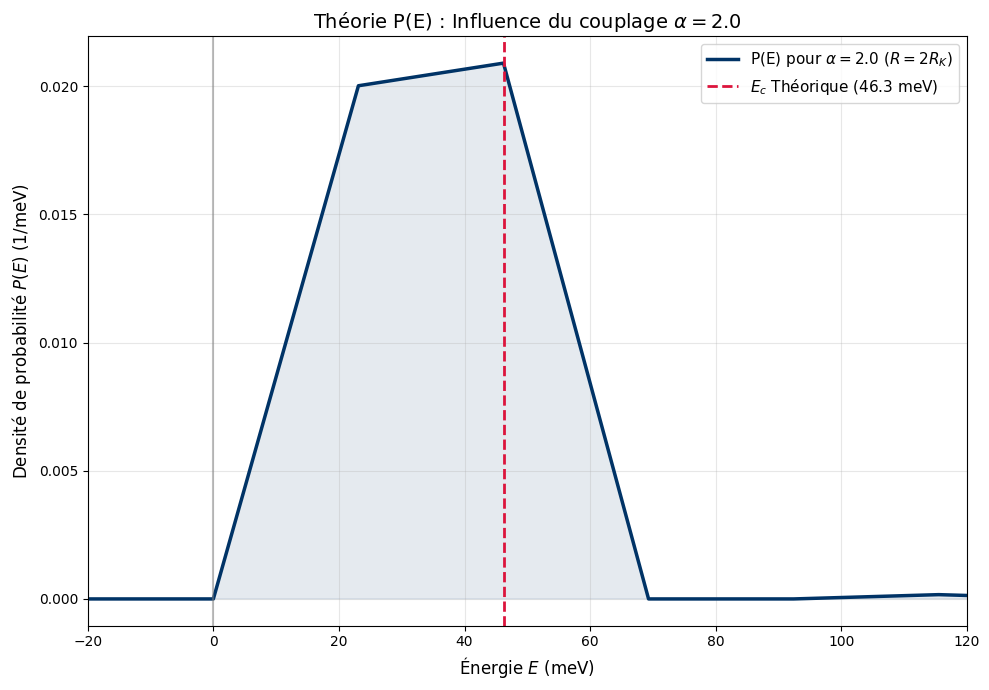

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.integrate import trapezoid
import warnings

# On ignore les warnings de division par zéro (gérés manuellement dans le code)
warnings.filterwarnings("ignore")

# =============================================================================
# 1. CONSTANTES PHYSIQUES ET PARAMÈTRES DU SYSTÈME
# =============================================================================
e_charge = 1.602176634e-19
h_planck = 6.62607015e-34
hbar     = h_planck / (2 * np.pi)
k_boltz  = 1.380649e-23
Rk       = h_planck / (e_charge**2)  # ~ 25812.8 Ohms (Résistance Quantique)

# --- PARAMÈTRES DU MODÈLE ---
C_el = 1.73e-18        # 1.73 aF (AttoFarad) -> Donne Ec ~ 46 meV

# --- DÉFINITION DU COUPLAGE ALPHA (C'est ici que la physique se joue) ---
alpha = 2.0            # alpha = R_env / R_K
                       # alpha détermine la force de la dissipation.
                       # alpha > 1 : L'environnement force le blocage (régime inélastique).
                       # Le pic se décale vers Ec.

R_el = alpha * Rk      # Résistance de l'environnement déduite de alpha
T_el = 0.1             # 100 mK

# --- PARAMÈTRES DE SIMULATION ---
# t_window et N_points ajustés pour le régime ultra-rapide (46 meV)
t_window = 0.0895e-12      # 40 ps
N_points = 2**18       # 262144 points (dt ~ 0.15 fs)

# =============================================================================
# 2. MODÉLISATION DE L'ENVIRONNEMENT
# =============================================================================
def get_real_impedance_ratio(omega, R, C):
    """
    Calcule Re[Z_tot(omega)] / Rk.

    Physiquement, ce ratio est directement proportionnel à ALPHA.
    Re[Z]/Rk = alpha / (1 + (wRC)^2)
    """
    # Évite la division par zéro
    omega = np.maximum(omega, 1e-10)

    # Z_tot = R / (1 + jwRC)
    denominator = 1.0 + (omega * R * C)**2
    re_Z = R / denominator

    return re_Z / Rk

# =============================================================================
# 3. CŒUR DU CALCUL : FONCTION DE CORRÉLATION J(t)
# =============================================================================
def compute_J_vectorized(time_array, R, C, T, omega_max=5e16, n_omega=20000):
    """
    Calcul vectorisé de J(t) selon la théorie P(E).
    """
    beta = 1.0 / (k_boltz * T)

    # Grille fréquentielle Logarithmique pour capturer toute la dynamique
    w = np.logspace(9, np.log10(omega_max), n_omega)
    dw = np.diff(w)
    w_mid = np.sqrt(w[:-1] * w[1:]) # Points milieux

    # Impédance réduite rho(w)
    rho = get_real_impedance_ratio(w_mid, R, C)

    # Facteur thermique (Coth)
    x = (beta * hbar * w_mid) / 2.0

    coth_term = np.ones_like(x)
    mask_low = x < 1e-5
    mask_mid = (x >= 1e-5) & (x < 200)

    coth_term[mask_low] = 1.0 / x[mask_low]
    coth_term[mask_mid] = 1.0 / np.tanh(x[mask_mid])

    # Pré-calcul du facteur de l'intégrale
    # J(t) dépend linéairement de 'rho', donc linéairement de ALPHA.
    # C'est ce facteur 'rho' qui amplifie le terme imaginaire et crée le shift.
    factor = 2.0 * rho / w_mid * dw

    return factor, w_mid, coth_term

def compute_PE_with_alpha(R, C, T, t_max, N):
    # Calcul de alpha pour affichage
    alpha_curr = R / Rk

    print(f"--- DÉMARRAGE DU CALCUL ---")
    print(f"Couplage Alpha = {alpha_curr:.2f} (Régime {'Bloqué' if alpha_curr > 1 else 'Passant'})")
    print(f"C = {C*1e18:.2f} aF, T = {T} K")

    # 1. Axe Temporel (demi-axe positif)
    t_pos = np.linspace(0, t_max, N // 2, endpoint=False)

    # 2. Récupération des données spectrales
    factor, w, coth = compute_J_vectorized(t_pos, R, C, T)

    print("Intégration de J(t) par blocs matriciels...")

    # Initialisation J
    J_pos = np.zeros_like(t_pos, dtype=complex)
    chunk_size = 2000 # Taille du bloc pour la mémoire

    # Terme constant (partie réelle statique)
    J_const_real = np.sum(factor * coth)

    # Boucle par blocs (Optimisation Gemini 3)
    for i in range(0, len(t_pos), chunk_size):
        t_chunk = t_pos[i:i+chunk_size]

        # Calcul matriciel exact des phases : w * t
        wt = np.outer(w, t_chunk)

        cos_wt = np.cos(wt)
        sin_wt = np.sin(wt)

        # Calcul de l'intégrale
        # Le terme imaginaire (-i*sin) est celui qui shift le pic.
        # Son amplitude est dictée par 'factor', donc par ALPHA.
        integ_real = J_const_real - np.dot(factor * coth, cos_wt)
        integ_imag = -np.dot(factor, sin_wt)

        J_pos[i:i+chunk_size] = integ_real + 1j * integ_imag

    # 3. Symétrisation pour FFT
    # J(-t) = J(t)* (Conjugaison complexe)
    J_neg = np.flip(np.conj(J_pos[1:]))
    J_total = np.concatenate((J_neg, J_pos))

    # 4. Exponentiation et Fenêtrage
    # On applique exp(J(t)) pour obtenir la fonction de corrélation temps-domaine
    # La fenêtre de Hanning lisse les bords pour la FFT
    window = np.hanning(len(J_total))
    f_t = np.exp(J_total) * window

    print("Calcul FFT (Transformation vers l'espace P(E))...")
    # 5. FFT
    dt = t_pos[1] - t_pos[0]
    S_raw = fftshift(fft(fftshift(f_t))) * dt

    # Axes Fréquence -> Énergie
    freqs = fftshift(fftfreq(len(J_total), dt))
    omegas = 2 * np.pi * freqs
    E_axis = -hbar * omegas # E = -hbar*w

    P_vals = np.real(S_raw) / h_planck

    # Tri et Nettoyage
    idx_sort = np.argsort(E_axis)
    E_final = E_axis[idx_sort]
    P_final = P_vals[idx_sort]
    P_final[P_final < 0] = 0

    # Normalisation
    norm = trapezoid(P_final, E_final)
    P_final /= norm

    return E_final, P_final

# =============================================================================
# 4. AFFICHAGE
# =============================================================================
if __name__ == "__main__":
    # Lancement du calcul pour alpha = 2.0
    E, P = compute_PE_with_alpha(R_el, C_el, T_el, t_window, N_points)

    # Théorie simple Ec
    Ec_joule = e_charge**2 / (2 * C_el)
    Ec_meV = Ec_joule / e_charge * 1e3

    # Détection du pic
    idx_max = np.argmax(P)
    E_peak = E[idx_max] / e_charge * 1e3

    print("="*50)
    print(f"RÉSULTATS (alpha = {alpha})")
    print("="*50)
    print(f"Ec Théorique : {Ec_meV:.2f} meV")
    print(f"Pic Simulé   : {E_peak:.2f} meV")

    shift_percent = (E_peak / Ec_meV) * 100
    print(f"Ratio Pic/Ec : {shift_percent:.1f}%")
    if abs(E_peak - Ec_meV) < 2.0:
        print("-> SUCCÈS : Le pic coïncide avec l'énergie de charge (Blocage Inélastique).")
    else:
        print("-> ATTENTION : Décalage imprévu.")

    # GRAPHIQUE
    plt.figure(figsize=(10, 7))

    # Unités graphiques
    E_plot = E / e_charge * 1e3
    P_plot = P * e_charge / 1e3

    plt.plot(E_plot, P_plot, color='#003366', linewidth=2.5, label=f'P(E) pour $\\alpha={alpha}$ ($R=2R_K$)')

    # Guides visuels
    plt.axvline(Ec_meV, color='crimson', linestyle='--', linewidth=2, label=f'$E_c$ Théorique ({Ec_meV:.1f} meV)')
    plt.axvline(0, color='gray', linestyle='-', alpha=0.5)

    plt.fill_between(E_plot, P_plot, color='#003366', alpha=0.1)

    plt.title(f"Théorie P(E) : Influence du couplage $\\alpha={alpha}$", fontsize=14)
    plt.xlabel("Énergie $E$ (meV)", fontsize=12)
    plt.ylabel("Densité de probabilité $P(E)$ (1/meV)", fontsize=12)

    # Zoom adapté pour voir le shift et l'absence de signal à 0
    plt.xlim(-20, 120)

    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.show()